In [34]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from scipy import stats
from scipy.interpolate import interp1d

from parameters import *
import aux
import save_n_load as sl

In [35]:
roc_curves = pickle.load(open("clf_min_10_100_hits_fp_tp_rates.pcl", "rb"))
print(roc_curves.keys)

fp_rates = {}
tp_rates = {}
for n_hits in range(1, 50):
    key = "n_hits_{}".format(n_hits)
    fp_rates[n_hits] = roc_curves[key]["fp_rate"]
    tp_rates[n_hits] = roc_curves[key]["tp_rate"]

<built-in method keys of dict object at 0x7fc5e9105080>


Text(0, 0.5, 'True positive rate')

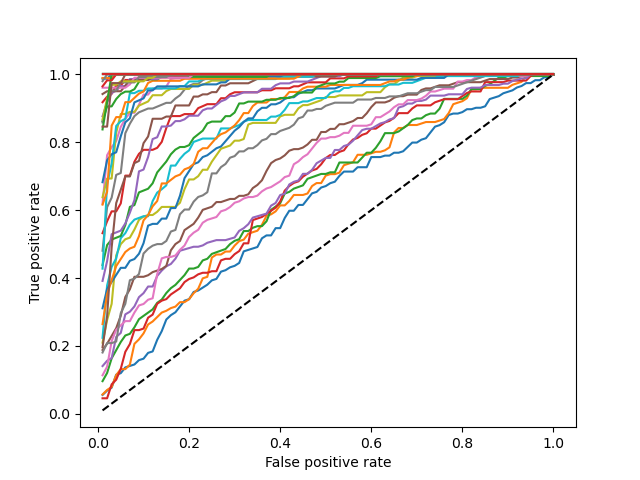

In [70]:
%matplotlib widget
# Convert these arrays into interpolated functions evaluatable at any point
# This is to make it easier to find the intersection point
fp_rates_interp = {}
tp_rates_interp = {}
for n_hits in range(1, 50):
    tp_rates_interp[n_hits] = interp1d(fp_rates[n_hits], tp_rates[n_hits]) # true positive rate as a function of false positive rate
    fp_rates_interp[n_hits] = interp1d(tp_rates[n_hits], fp_rates[n_hits])

for i in range(6, 50):
    x = np.linspace(0.01, 1, 100)
    plt.plot(x, tp_rates_interp[i](x), label="{} hits".format(i))

plt.plot(x, x, linestyle="--", color="black")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
#plt.legend()


In [52]:
# Load SN events
sn_total_hits, sn_hit_list_per_event, sn_info_per_event, _ = sl.load_all_sn_events_chunky(limit=100, event_num=1000, detector="VD")
sn_energies = np.array([event[0] for event in sn_info_per_event])
sn_hit_multiplicities = np.array([len(event) for event in sn_hit_list_per_event])

prodmarley_nue_dune10kt_vd_1x8x14_larger_1665503720.164629959_g4_detsim_aronly_reco_hist.root
prodmarley_nue_dune10kt_vd_1x8x14_larger_1665503722.923528965_g4_detsim_aronly_reco_hist.root
prodmarley_nue_dune10kt_vd_1x8x14_larger_1665503741.863016959_g4_detsim_aronly_reco_hist.root
prodmarley_nue_dune10kt_vd_1x8x14_larger_1665503651.872521898_g4_detsim_aronly_reco_hist.root
prodmarley_nue_dune10kt_vd_1x8x14_larger_1669195327.944994769_g4_detsim_aronly_reco_hist.root
prodmarley_nue_dune10kt_vd_1x8x14_larger_1665503723.767603975_g4_detsim_aronly_reco_hist.root
prodmarley_nue_dune10kt_vd_1x8x14_larger_1665503863.684946615_g4_detsim_aronly_reco_hist.root
prodmarley_nue_dune10kt_vd_1x8x14_larger_1665503683.506104157_g4_detsim_aronly_reco_hist.root
prodmarley_nue_dune10kt_vd_1x8x14_larger_1665503870.279759231_g4_detsim_aronly_reco_hist.root
prodmarley_nue_dune10kt_vd_1x8x14_larger_1669195422.425837687_g4_detsim_aronly_reco_hist.root
prodmarley_nue_dune10kt_vd_1x8x14_larger_1665503867.39291695

In [53]:
# Load BG events and get average bg rate
bg_limit = 100
bg_length = bg_limit * BG_SAMPLE_LENGTHS["VD"] # in miliseconds
bg_total_hits, bg_hit_list_per_event, _, _, _ = sl.load_all_backgrounds_chunky_type_separated(limit=bg_limit, detector="VD")

prodbg_radiological_dune10kt_vd_1x8x14_1669903578.301321786_Ar39GenInLAr_g4_detsim_aronly_reco_hist.root
prodbg_radiological_dune10kt_vd_1x8x14_1669902898.078344135_Ar39GenInLAr_g4_detsim_aronly_reco_hist.root
prodbg_radiological_dune10kt_vd_1x8x14_1669906613.930993415_Ar39GenInLAr_g4_detsim_aronly_reco_hist.root
prodbg_radiological_dune10kt_vd_1x8x14_1669902735.920514858_Ar39GenInLAr_g4_detsim_aronly_reco_hist.root
prodbg_radiological_dune10kt_vd_1x8x14_1669902713.636132148_Ar39GenInLAr_g4_detsim_aronly_reco_hist.root
prodbg_radiological_dune10kt_vd_1x8x14_1669906356.844701182_Ar39GenInLAr_g4_detsim_aronly_reco_hist.root
prodbg_radiological_dune10kt_vd_1x8x14_1669904711.165598892_Ar39GenInLAr_g4_detsim_aronly_reco_hist.root
prodbg_radiological_dune10kt_vd_1x8x14_1669902703.325449278_Ar39GenInLAr_g4_detsim_aronly_reco_hist.root
prodbg_radiological_dune10kt_vd_1x8x14_1669904736.659844379_Ar39GenInLAr_g4_detsim_aronly_reco_hist.root
prodbg_radiological_dune10kt_vd_1x8x14_1669902551.16444

In [55]:
bg_rates = []
for hit_list in bg_hit_list_per_event:
    bg_rates.append(len(hit_list) / 8.5)

bg_rate = np.mean(bg_rates)
print(bg_rate)

390.18123529411764


In [83]:
def eff_check(sn_hit_multiplicities, false_positive_rate=0.1, min_hits=10, distance=5, cluster_size=100, bg_rate_per_ms=113.5, test_num=100,
                average_e=23.0, alpha=5.0, normalization="GKVM"):

    btr = BURST_TIME_WINDOW
    ftr = FAKE_TRIGGER_RATE

    expected_bg_hits_per_burst = bg_rate_per_ms * btr / 1000
    expected_bg_per_burst = expected_bg_hits_per_burst / cluster_size * false_positive_rate

    tpx, tpy = sl.load_time_profile()
    event_num = aux.distance_to_event_number(distance, model=normalization)
    event_num_per_time = aux.event_number_per_time(tpx, tpy, event_num, btr) * SN_EVENT_MULTIPLIER

    # For a supernova event, calculate the average number of events, and the average number of hits per event
    energies = np.linspace(4, 200, 100)
    energies_histogram = aux.pinched_spectrum(energies, average_e=average_e, alpha=alpha)

    # -------
    triggers = 0
    for i in range(test_num):
        # Draw a true event number from the expected event number.
        r = int(stats.poisson.rvs(event_num_per_time, size=1))
        #print(r)

        # Draw randomly from the SN event pool, while following a given energy distribution!
        sample_ind_e = aux.get_energy_indices(energies, energies_histogram, sn_energies, size=r)
        selected_energies = sn_energies[sample_ind_e]
        sn_hit_multiplicities = np.array(sn_hit_multiplicities)
        sample = sn_hit_multiplicities[sample_ind_e]

        # Get the true positive rates for each event, dependent on the number of hits
        sn_per_burst = 0
        for hm in sample:
            if hm > 49:
                hm = 49

            if hm < min_hits:
                sn_prob = 0 #false_positive_rate
            else:
                sn_prob = tp_rates_interp[hm](false_positive_rate) # true positive rate as a function of false positive rate
            
            if sn_prob > np.random.rand():
                sn_per_burst += 1
        
        observed = int(sn_per_burst + stats.poisson.rvs(expected_bg_per_burst, size=1))

        bg_hits_this_burst = stats.poisson.rvs(expected_bg_hits_per_burst, size=1)
        sn_hits_this_burst = np.sum(sample)
        total_hits_this_burst = bg_hits_this_burst + sn_hits_this_burst
        cluster_num = int(total_hits_this_burst / cluster_size) * false_positive_rate + sn_per_burst

        #print(expected_bg_per_burst, sn_per_burst, observed)

        # Poisson likelihood
        p = 1 - stats.poisson.cdf(cluster_num - 1, expected_bg_per_burst)
        print(p, cluster_num, expected_bg_per_burst)
        #print(p, ftr)
        if p <= ftr:
            triggers += 1

    efficiency = triggers / test_num

    return efficiency
    # plt.figure()
    # plt.plot(energies_histogram)
    # plt.hist(selected_energies, bins=100, density=True)

    # plt.figure()
    # plt.hist(sample, bins=100, density=True)

In [84]:
fprs = np.linspace(0.005, 0.99, 50)
effs = []

for false_positive_rate in fprs:#[0.02, 0.05, 0.1, 0.2, 0.3, 0.5, 0.6, 0.7, 0.95]:
    efficiency = eff_check(sn_hit_multiplicities, false_positive_rate=false_positive_rate, distance=20, min_hits=1, cluster_size=100, bg_rate_per_ms=bg_rate, 
                                test_num=100, average_e=23.0, alpha=5.0, normalization="GKVM")
    print(false_positive_rate, efficiency)
    effs.append(efficiency)


0.062269550314460465 27.555 19.509061764705883
0.062269550314460465 27.535 19.509061764705883
0.24262193627647977 23.555 19.509061764705883
0.026266431850751393 29.505 19.509061764705883
0.24262193627647977 23.580000000000002 19.509061764705883
0.13077270560262344 25.490000000000002 19.509061764705883
0.13077270560262344 25.51 19.509061764705883
0.13077270560262344 25.55 19.509061764705883
0.026266431850751393 29.465 19.509061764705883
0.0009922911109914168 35.58 19.509061764705883
0.09163583992297242 26.57 19.509061764705883
0.041050707433990086 28.515 19.509061764705883
0.31535903547009936 22.545 19.509061764705883
0.09163583992297242 26.525000000000002 19.509061764705883
0.041050707433990086 28.53 19.509061764705883
0.041050707433990086 28.575 19.509061764705883
0.3973832866390923 21.535 19.509061764705883
0.31535903547009936 22.505 19.509061764705883
0.1809248684176159 24.515 19.509061764705883
0.041050707433990086 28.51 19.509061764705883
0.026266431850751393 29.515 19.50906176470

KeyboardInterrupt: 

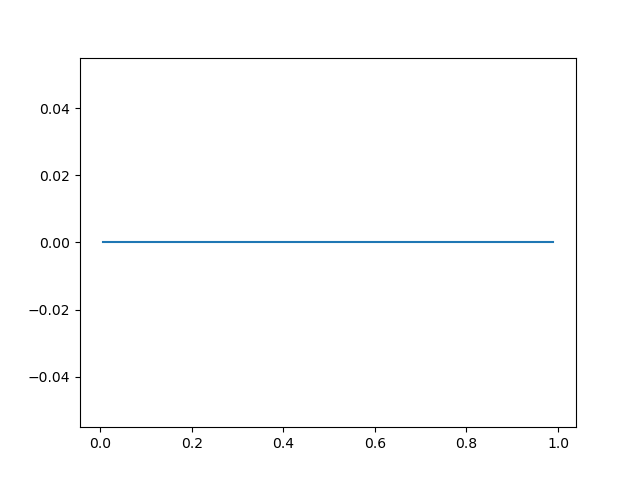

In [80]:
plt.figure()
plt.plot(fprs, effs)